In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.applications import MobileNet
from keras.utils import Sequence
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

dataset_code = 'B'
model_name = 'MobileNet'
data_saved_dir = r'D:\My Code\Classification\pickle_data'
train_data_path = os.path.join(data_saved_dir, f'{dataset_code}_training.pkl')
train_images, train_labels = load_pickle(train_data_path)

val_data_path = os.path.join(data_saved_dir, 'validation_data.pkl')
val_images, val_labels = load_pickle(val_data_path)

In [3]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_images = self.images[start:end]
        batch_labels = self.labels[start:end]
        return batch_images, batch_labels

batch_size = 16
train_data_generator = CustomDataGenerator(train_images, train_labels, batch_size)
val_data_generator = CustomDataGenerator(val_images, val_labels, batch_size)

In [4]:
_mobile_net = MobileNet(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

model = Sequential()
model.add(_mobile_net)

for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(units=2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 2048)              134219776 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 137,450,689
Trainable params: 134,221,825
Non-trainable params: 3,228,864
__________________________________

In [5]:
history = model.fit(train_data_generator, epochs=50, validation_data=val_data_generator)

Epoch 1/50
130/130 [==============================] - 9s 47ms/step - loss: 6.3553 - accuracy: 0.8474 - val_loss: 3.3964 - val_accuracy: 0.8494
Epoch 2/50
130/130 [==============================] - 5s 39ms/step - loss: 1.0512 - accuracy: 0.9417 - val_loss: 1.0681 - val_accuracy: 0.9247
Epoch 3/50
130/130 [==============================] - 5s 41ms/step - loss: 0.3155 - accuracy: 0.9788 - val_loss: 1.7826 - val_accuracy: 0.9121
Epoch 4/50
130/130 [==============================] - 5s 39ms/step - loss: 0.2456 - accuracy: 0.9788 - val_loss: 1.1421 - val_accuracy: 0.9205
Epoch 5/50
130/130 [==============================] - 5s 38ms/step - loss: 0.0917 - accuracy: 0.9889 - val_loss: 0.8676 - val_accuracy: 0.9456
Epoch 6/50
130/130 [==============================] - 5s 38ms/step - loss: 0.0742 - accuracy: 0.9894 - val_loss: 1.0655 - val_accuracy: 0.9247
Epoch 7/50
130/130 [==============================] - 5s 37ms/step - loss: 0.0465 - accuracy: 0.9918 - val_loss: 1.6458 - val_accuracy: 0.9205

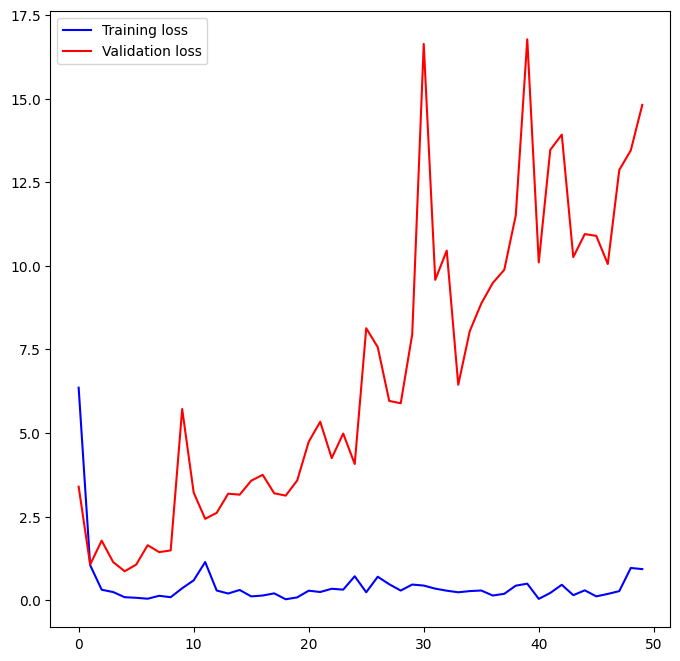

<Figure size 640x480 with 0 Axes>

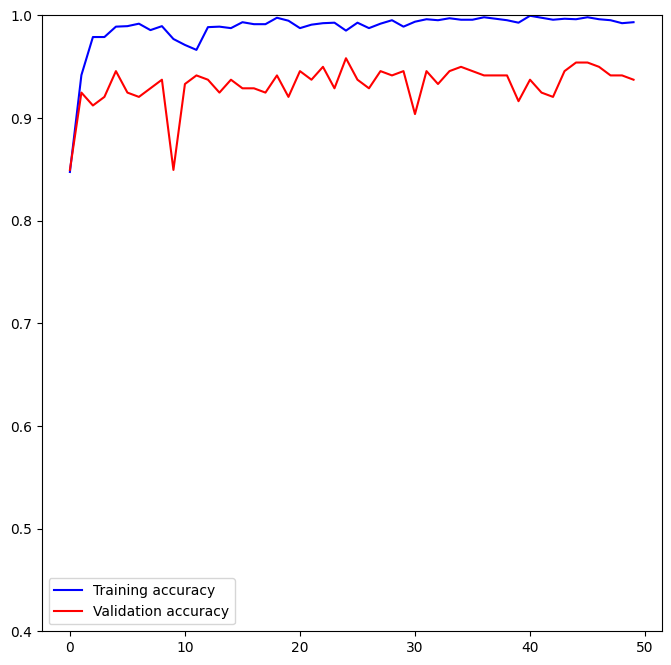

In [6]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.ylim(0.4, 1)
plt.show()

8/8 [==============================] - 1s 50ms/step


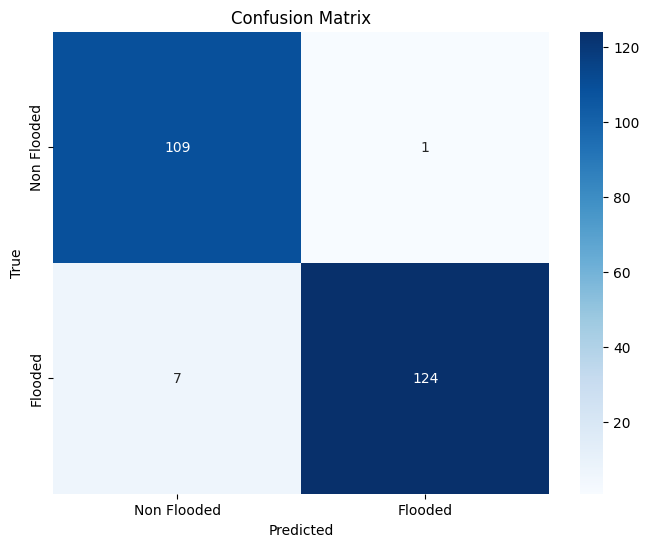

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       110
           1       0.99      0.95      0.97       131

    accuracy                           0.97       241
   macro avg       0.97      0.97      0.97       241
weighted avg       0.97      0.97      0.97       241



In [7]:
test_data_path = os.path.join(data_saved_dir, 'test_data.pkl')
test_images, test_labels = load_pickle(test_data_path)

predictions = model.predict(test_images)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

In [8]:
model_saved = r'D:\My Code\Classification\models'
model.save(os.path.join(model_saved, f'{dataset_code}_{model_name} (256X256).h5'))